# A5 Convolutional Neural Networks

*Md Fahim Hasan*

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A5-Convolutional-Neural-Networks" data-toc-modified-id="A5-Convolutional-Neural-Networks-1">A5 Convolutional Neural Networks</a></span><ul class="toc-item"><li><span><a href="#Simple-Images" data-toc-modified-id="Simple-Images-1.1">Simple Images</a></span></li><li><span><a href="#Requirements" data-toc-modified-id="Requirements-1.2">Requirements</a></span><ul class="toc-item"><li><span><a href="#Plus,-Minus,-Times,-Divide" data-toc-modified-id="Plus,-Minus,-Times,-Divide-1.2.1">Plus, Minus, Times, Divide</a></span></li><li><span><a href="#Real-Images-from-CIFAR-10" data-toc-modified-id="Real-Images-from-CIFAR-10-1.2.2">Real Images from CIFAR-10</a></span></li></ul></li></ul></li><li><span><a href="#Grading" data-toc-modified-id="Grading-2">Grading</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-3">Extra Credit</a></span></li></ul></div>

For this assignment, use the `ConvNet` class defined for you in Lecture Notes 13.  Cut and paste the contents of the `ConvNet` code cell into a file named `convnet.py`.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd  # for display and clear_output
import time

import convnet

## Simple Images

Here is a function that generates a simple, fun, data set consisting of four classes of image that we can call `plus`, `minus`, `times` and `divide`.

In [2]:
def make_images(n_each_class):

    n_samples = n_each_class * 4
    
    images = np.zeros((n_samples, 20, 20))  # nSamples, rows, columns
    labels = np.zeros(n_samples)
    label_names = ['plus', 'minus', 'times', 'divide']
    
    radii = 3 + np.random.randint(10 - 5, size=(n_samples, 1))
    centers = np.zeros((n_samples, 2))
    
    for sample_i in range(0, n_samples, 4):
        r = radii[sample_i, 0]
        centers[sample_i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[sample_i, 0])
        y = int(centers[sample_i, 1])
        
        for class_i in range(4):
            
            if class_i == 0:
                # plus
                images[sample_i, x - r:x + r, y] = 1.0
                images[sample_i, x, y - r:y + r] = 1.0
                labels[sample_i] = 0

            elif class_i == 1:
                # minus
                images[sample_i + 1, x, y - r:y + r] = 1.0
                labels[sample_i + 1] = 1

            elif class_i == 2:
                # times
                images[sample_i + 2, range(x - r, x + r), range(y - r, y + r)] = 1.0
                images[sample_i + 2, range(x - r, x + r), range(y + r, y - r, -1)] = 1.0
                labels[sample_i + 2] = 2

            else:  # class_i == 3
                # divide
                images[sample_i + 3, range(x - r, x + r), range(y + r, y - r, -1)] = 1.0
                labels[sample_i + 3] = 3

    n, r, c = images.shape
    images = images.reshape(n, r, c)  # add channel dimension
    return images, labels, label_names

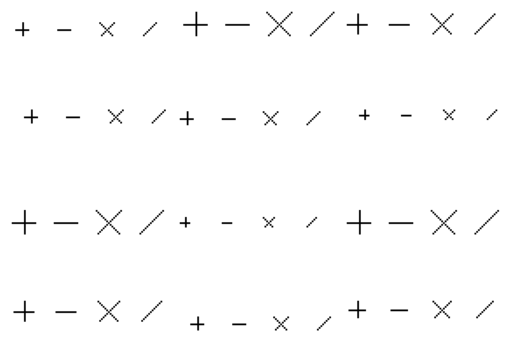

In [3]:
n_each_class = 12

X, T, label_names = make_images(n_each_class)

p = 0
for i in range(X.shape[0]):
    p += 1
    plt.subplot(4, 4 * 3, p)
    plt.imshow(-X[i, :, :], cmap='gray')
    plt.axis('off')

Let's make 500 samples in each class and train our convolutional neural net on this data. Remember to add the channel dimension, of size 1, because we have just one intensity per pixel.  

In [4]:
n_each_class = 500
X, T, label_names = make_images(n_each_class)
X = X.reshape(-1, 1, 20, 20)

In [5]:
T, label_names

(array([0., 1., 2., ..., 1., 2., 3.]), ['plus', 'minus', 'times', 'divide'])

We will train on the first 80% of the samples, validate on the next 10% and test on the remaining 10%.

In [6]:
X.shape[0] # total samples

2000

In [7]:
n_samples = X.shape[0]
ntrain = int(n_samples * 0.8)
nval = int(n_samples * 0.1)

Xtrain = X[:ntrain, :]
Ttrain = T[:ntrain]

Xval = X[ntrain:ntrain + nval, ...]
Tval = T[ntrain:ntrain + nval]
         
Xtest = X[ntrain + nval:, ...]
Ttest = T[ntrain + nval:]

Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((1600, 1, 20, 20),
 (1600,),
 (200, 1, 20, 20),
 (200,),
 (200, 1, 20, 20),
 (200,))

In [16]:
input_shape = X.shape[1:]
n_hiddens_per_conv_layer = [5]
patch_size_per_conv_layer = [5]
stride_per_conv_layer = [1]
n_hiddens_per_fc_layer = [10]
n_outputs = 4

batch_size = -1  # means we will not divide training data into batches while training
learning_rate = 0.01
method = 'adam'
n_epochs = 5
n_reps = 50

device = 'cuda'   # or 'cuda'
nnet = convnet.ConvNet(input_shape,
                       n_hiddens_per_conv_layer, 
                       n_hiddens_per_fc_layer,
                       n_outputs,
                       patch_size_per_conv_layer, 
                       stride_per_conv_layer, device=device)

Accuracy Train 100.0 Val 94.0 Test 96.5
Training took 0.62 minutes.


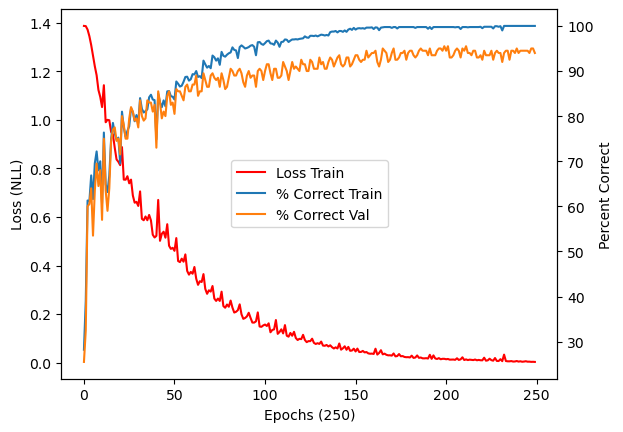

In [17]:
current_length = len(nnet.get_loss_trace())  # in case training existing net again

fig = plt.figure()
start_time = time.time()

for reps in range(n_reps):
    nnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method=method,
            Xval=Xval, Tval=Tval, verbose=False)

    plt.clf()
    ax = fig.add_subplot(111)
    loss_trace = nnet.get_loss_trace()
    plot1 = ax.plot(loss_trace, 'r-')
    ax.set_ylabel('Loss (NLL)')
    ax.set_xlabel('Epochs ({})'.format(current_length + n_reps * n_epochs))

    acc_train = nnet.percent_correct(nnet.use(Xtrain)[0], Ttrain)
    acc_test = nnet.percent_correct(nnet.use(Xtest)[0], Ttest)
    accuracies = nnet.get_accuracy_trace()
    xs = range(0, len(loss_trace), len(loss_trace) // len(accuracies))

    ax2 = ax.twinx()
    plot2 = ax2.plot(xs, accuracies)
    ax2.set_ylabel('Percent Correct')

    plots = plot1 + plot2
    if len(plot2) == 1:
        ax.legend(plots, ('Loss Train', '% Correct Train'), loc='upper center')
    else:
        ax.legend(plots, ('Loss Train', '% Correct Train', '% Correct Val'), loc='center')

    # plt.xlim(0, n_epochs * n_reps)
    
    ipd.clear_output(wait=True)
    ipd.display(fig)
    
ipd.clear_output(wait=True)

acc_train = nnet.percent_correct(nnet.use(Xtrain)[0], Ttrain)
acc_val = nnet.percent_correct(nnet.use(Xval)[0], Tval)
acc_test = nnet.percent_correct(nnet.use(Xtest)[0], Ttest)
print('Accuracy Train', acc_train, 'Val', acc_val, 'Test', acc_test)

print('Training took {:.2f} minutes.'.format((time.time() - start_time)/60.0))

## Requirements

### Plus, Minus, Times, Divide

1. Run all of the above cells.
2. Draw at least 12 `Xtest` images that are correctly classified.  Use `plt.title` to specify the actual and predicted class names, using strings like `'{}\n{}'.format(label_names[Ttest[i]], label_names[Ytest[i]]`.
2. Draw some `Xtest` images that are incorrectly classified.  Again, title each image as you did in step 2.
3. Examine the weights in the first layer.  Draw the weights as images.  Do they make sense, given the kinds of images you are classifying? 
Try changing the network structure and retrain several times to try to make your weight images easier to interpret.

## Draw at least 12 Xtest images that are correctly classified

In [18]:
# # Observed data labels
# Ttest 
# nnet.use(Xtest)[0] # will give predicted labels of Xtest

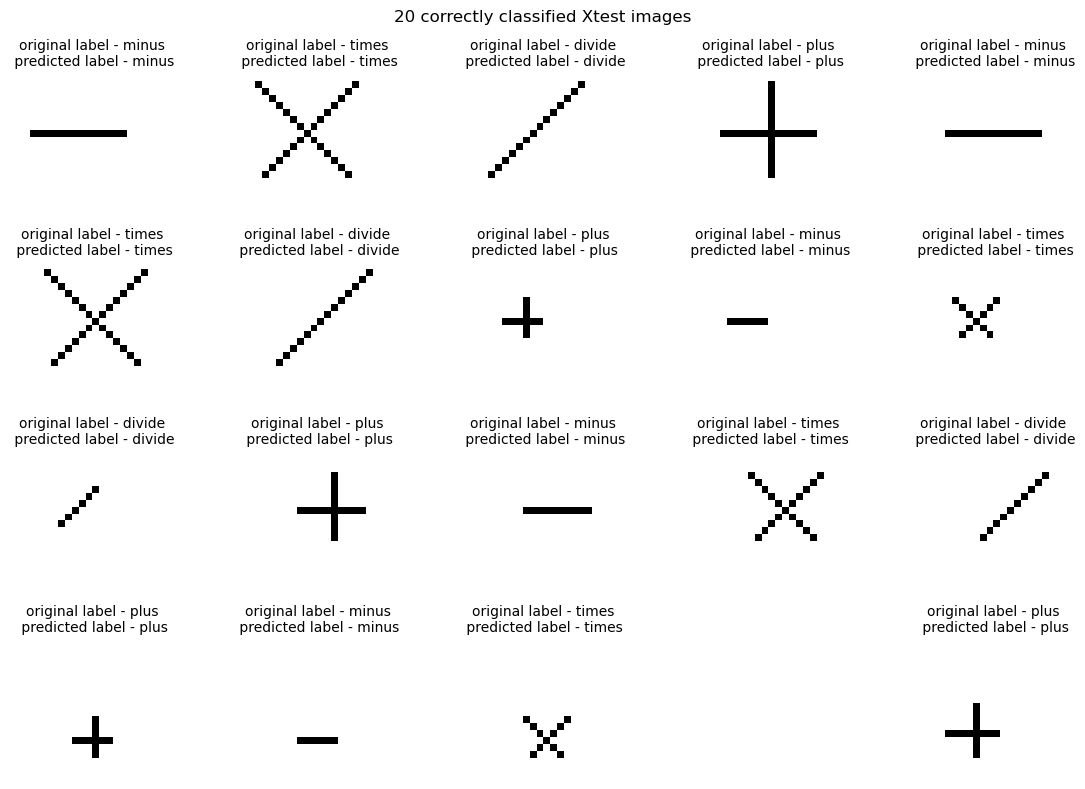

In [19]:
# Running model for test data
Ytest_predicted = nnet.use(Xtest)
Ytest_label = Ytest_predicted[0]

# Drawing some correctly classified Xtest images
images_to_draw = 20  # provide numbers multiple of 5 (for nrow and ncol in plot) 
nrow, ncol = int(images_to_draw/ 5), 5


img_drawn = 0
plt.subplots(figsize=(12, 8))
for i in range(1, 100):
    if img_drawn < images_to_draw:
        if Ttest[i] == Ytest_label[i]:
            img_drawn += 1
            plt.subplot(nrow, ncol, i)
            plt.imshow(-Xtest[i, :, :].squeeze(), cmap='gray')
            plt.title('original label - {}\n predicted label - {}'.format(label_names[int(Ttest[i])], label_names[int(Ytest_label[i])]),  
                      fontsize=10)
            plt.axis('off')
        plt.suptitle(f'{images_to_draw} correctly classified Xtest images')
        plt.tight_layout()

## Draw some Xtest images that are incorrectly classified

In [20]:
# Identifying incorrect predictions

incorrect_found = []

for i in range(1, 200):
    if Ttest[i] == Ytest_label[i]:
        pass
    else:
        print('incorr', i)
        incorrect_found.append(i)

incorr 34
incorr 84
incorr 87
incorr 150
incorr 151
incorr 184
incorr 195


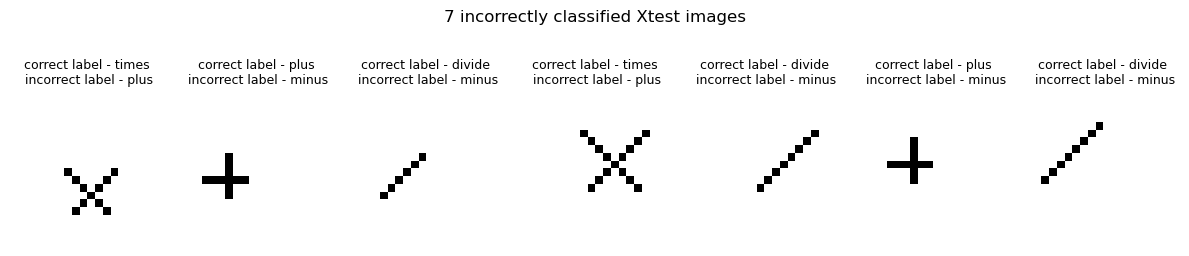

In [22]:
# Drawing incorrectly classified Xtest images
images_to_draw = len(incorrect_found) 
nrow, ncol = 1, images_to_draw

plot_pos = 0
plt.subplots(figsize=(12, 3))
for i in range(1, 200):
    if Ttest[i] != Ytest_label[i]:
        plot_pos += 1 
        plt.subplot(nrow, ncol, plot_pos)
        plt.imshow(-Xtest[i, :, :].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title('correct label - {}\n incorrect label - {}'.format(label_names[int(Ttest[i])], label_names[int(Ytest_label[i])]),
                  fontsize=9)
    plt.suptitle(f'{images_to_draw} incorrectly classified Xtest images')
    plt.tight_layout()

## Examine the weights in the first layer. Draw the weights as images. Do they make sense, given the kinds of images you are classifying? 

In [23]:
# Extracting first weight
print(list(nnet.children()))
layerweights_1 = list(nnet.children())[0][0].weight.data
# layerweights_1.shape  # the shape consists of (hidden layer in CNN, 1, Patch dimesion, Patch dimesion)

[ModuleList(
  (0): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
), ModuleList(
  (0): Linear(in_features=1280, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=4, bias=True)
)]


(-0.5, 19.5, 19.5, -0.5)

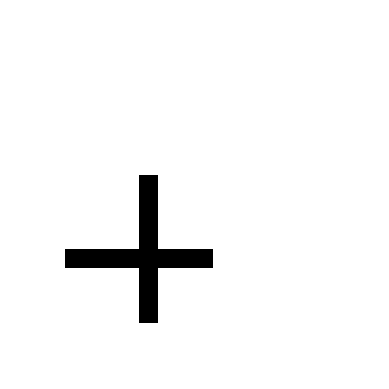

In [24]:
x = Xtest[20:21]  # Taking 1 Image from Xtest and plotting it

plt.imshow(-x.squeeze(), cmap='gray')
plt.axis('off')

### **This is a plus sign. I will be analyzing if cnn weights can show patterns indicating the `plus` sign**

In [25]:
x = torch.from_numpy(x).float().to(device)
Ys = nnet._forward_all_outputs(x)

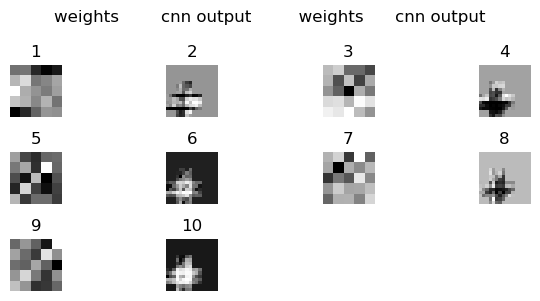

In [26]:
max_plot = layerweights_1.shape[0] *2  # taking first dimension of layerweight as the max plotting number

ploti = 0
for i in range(10):
    if ploti < max_plot:
        ploti += 1
        plt.subplot(5, 4, ploti)
        plt.imshow(layerweights_1[i].squeeze().cpu(), cmap='gray')
        plt.title(ploti)
        plt.axis('off')
        ploti += 1
        plt.subplot(5, 4, ploti)
        plt.imshow(Ys[1][0, i, :, :].detach().squeeze().cpu(), cmap='gray')
        plt.title(ploti)
        plt.axis('off')
    plt.suptitle('weights        cnn output         weights      cnn output')
    plt.tight_layout()

The 1st and 3rd columns in the above plots are the first`weights` in the cnn hidden layer (title no- 1, 3, 5, 7, 9). The 2nd and 4th columns are the `convolved weights` (output after activation function) after the cnn hidden layer (title no - 2, 4, 6, 8, 10). 

After a close look, it seems difficult to understand whether the `weights` show any pattern of the symbol it is representing (plus here). However, compared to these `weights`, the `convolved weights` are much more interpretable. All of them show recognizable patterns indicating the plus symbol. 

## Try changing the network structure and retrain several times to try to make your weight images easier to interpret.

In [28]:
# Training a new model (model 2)

input_shape = X.shape[1:]
n_hiddens_per_conv_layer = [10]
patch_size_per_conv_layer = [6]
stride_per_conv_layer = [2]
n_hiddens_per_fc_layer = [10]
n_outputs = 4

batch_size = -1  # means we will not divide training data into batches while training
learning_rate = 0.01
method = 'adam'
n_epochs = 15
n_reps = 50

device = 'cuda'   # or 'cuda'
nnet2 = convnet.ConvNet(input_shape,
                        n_hiddens_per_conv_layer, 
                        n_hiddens_per_fc_layer,
                        n_outputs,
                        patch_size_per_conv_layer, 
                        stride_per_conv_layer, device=device)

nnet2.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method=method,
            Xval=Xval, Tval=Tval, verbose=False)

ConvNet(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(6, 6), stride=(2, 2))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=640, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=4, bias=True)
  )
)

(-0.5, 19.5, 19.5, -0.5)

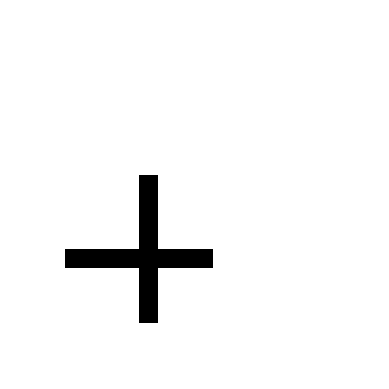

In [86]:
x2 = Xtest[20:21]

plt.imshow(-x2.squeeze(), cmap='gray')
plt.axis('off')

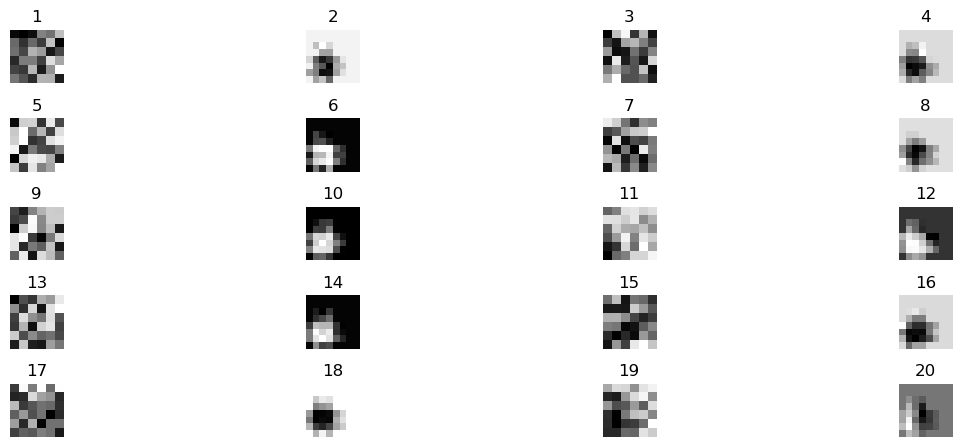

In [87]:
layerweights_2 = list(nnet2.children())[0][0].weight.data  # layerweights_2 is 1st weight of 2nd cnn model nnet2

x2 = torch.from_numpy(x2).float().to(device)
Ys = nnet2._forward_all_outputs(x2)
# Ys[1][0, 0, :, :]

max_plot = layerweights_2.shape[0] * 2

ploti = 0
plt.subplots(figsize=(12, 9))
for i in range(20):
    if ploti < max_plot:
        ploti+=1
        plt.subplot(10, 4, ploti)
        plt.imshow(layerweights_2[i].squeeze().cpu(), cmap='gray')
        plt.title(ploti)
        plt.axis('off')
        ploti+=1
        plt.subplot(10, 4, ploti)
        plt.imshow(Ys[1][0, i, :, :].detach().squeeze().cpu(), cmap='gray')
        plt.title(ploti)
        plt.axis('off')
    plt.tight_layout()

I trained a new model with more unit in convolution hidden layer (10), increased patch size (6), and changing stride to 2 with a goal to assess if the `weights` and `convolved weights` are differnt with a new model structure.

Looks like increasing number of convolution hidden layers and patch size doesn't improve interpretability. The `weights` are (column 1 and 3) again impossible to interpret as plus sign. `convolved weights`(column 2 and 4) are interpretable as plus sign but not as much as the first cnn model `nnet`. 

In [108]:
# Training a new model (model 3)

input_shape = X.shape[1:]
n_hiddens_per_conv_layer = [3]
patch_size_per_conv_layer = [6]
stride_per_conv_layer = [2]
n_hiddens_per_fc_layer = [10]
n_outputs = 4

batch_size = -1  # means we will not divide training data into batches while training
learning_rate = 0.01
method = 'adam'
n_epochs = 15
n_reps = 50

device = 'cuda'   # or 'cuda'
nnet3 = convnet.ConvNet(input_shape,
                        n_hiddens_per_conv_layer, 
                        n_hiddens_per_fc_layer,
                        n_outputs,
                        patch_size_per_conv_layer, 
                        stride_per_conv_layer, device=device)

nnet3.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method=method,
            Xval=Xval, Tval=Tval, verbose=False)

ConvNet(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(6, 6), stride=(2, 2))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=192, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=4, bias=True)
  )
)

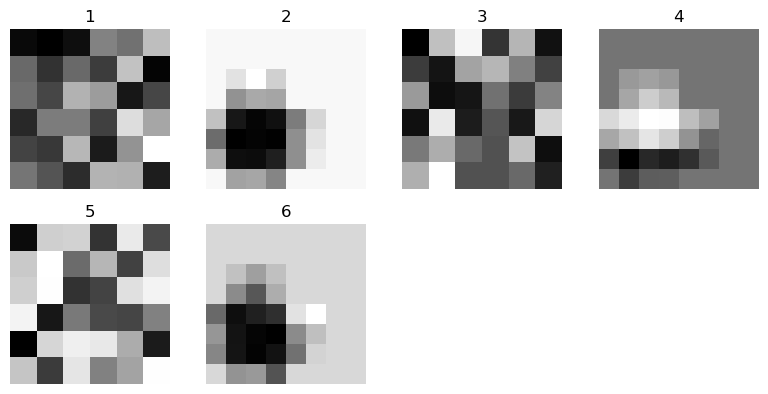

In [110]:
layerweights_3 = list(nnet3.children())[0][0].weight.data  # layerweights_3 is 1st weight of 3rd cnn model nnet3

x3 = Xtest[20:21]  # the plus sign
x3 = torch.from_numpy(x3).float().to(device)
Ys = nnet3._forward_all_outputs(x3)
# Ys[1][0, 0, :, :]

max_plot = layerweights_3.shape[0] * 2

ploti = 0
plt.subplots(figsize=(8, 6))
for i in range(20):
    if ploti < max_plot:
        ploti+=1
        plt.subplot(3, 4, ploti)
        plt.imshow(layerweights_2[i].squeeze().cpu(), cmap='gray')
        plt.title(ploti)
        plt.axis('off')
        ploti+=1
        plt.subplot(3, 4, ploti)
        plt.imshow(Ys[1][0, i, :, :].detach().squeeze().cpu(), cmap='gray')
        plt.title(ploti)
        plt.axis('off')
    plt.tight_layout()

This time, I tried with a different model structure with reduced number of units in convolution hidden layer (3). The decreasing number of convolution hidden layers doesn't improve interpretability. Like before, the `weights` are (column 1 and 3) impossible to interpret as plus sign. `convolved weights`(column 2 and 4) are interpretable as plus sign and mthe pattern is more visible than model 2 `nnet2`.

In conclusion, the number of hidden unit in convolution hidden layer doesn't change interpretability of 1st weights of the cnn model. However, `convolved weights` are very recognizable in any network structure, especially with lesser number of hidden units they are more identifiable (i.e., `nnet3`). The primary reason might be the activation function. It modifies the `weights` and make the symbol interpretable in `convolved weights`.

### Real Images from CIFAR-10

Download the `CIFAR-10 python version` data from [ Alex Krizhevsky's home page](https://www.cs.toronto.edu/~kriz/cifar.html).  Extract the data from the tar file and read the data using the following code.  We will take the first 5,000 images as training data, the next 5,000 as validation data, and the next 5,000 images as test data.

In [3]:
import pickle

with open('./cifar-10-batches-py/batches.meta', 'rb') as f:
     d = pickle.load(f, encoding='bytes')

label_names = [z.decode() for z in d[b'label_names']]

X = []
T = []

for batch in ['data_batch_1', 'data_batch_2']:
    with open('cifar-10-batches-py/' + batch, 'rb') as f:
        d = pickle.load(f, encoding='bytes')

    X_batch = d[b'data']
    T_batch = np.array(d[b'labels'])

    X.append(X_batch)
    T.append(T_batch)
    
X = np.vstack(X)
T = np.hstack(T)

print(X.shape, T.shape)

X = X.reshape(-1, 3, 32, 32)
# T = T.reshape(-1, 1)

n_train = 5000
n_val = 5000
n_test = 5000

first = 0
last = n_train + first
Xtrain = X[first:last, ...]
Ttrain = T[first:last]

first = last
last = last + n_val
Xval = X[first:last, ...]
Tval = T[first:last, ...]

first = last
last = last + n_test
Xtest = X[first:last, ...]
Ttest = T[first:last]

Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

(20000, 3072) (20000,)


((5000, 3, 32, 32),
 (5000,),
 (5000, 3, 32, 32),
 (5000,),
 (5000, 3, 32, 32),
 (5000,))

In [4]:
def run_experiment(n_hiddens_per_conv_layer,
                   patch_size_per_conv_layer,
                   stride_per_conv_layer,
                   n_hiddens_per_fc_layer,
                   batch_size,
                   learning_rate,
                   method,
                   n_epochs,
                   n_reps,
                   device):
    
    input_shape = [3, 32, 32]
    n_outputs = 10

    nnet = convnet.ConvNet(input_shape,
                           n_hiddens_per_conv_layer, 
                           n_hiddens_per_fc_layer,
                           n_outputs,
                           patch_size_per_conv_layer, 
                           stride_per_conv_layer, device=device)


    current_length = len(nnet.get_loss_trace())

    fig = plt.figure()
    start_time = time.time()

    for reps in range(n_reps):
        nnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method=method,
                Xval=Xval, Tval=Tval, verbose=False)
        plt.clf()
        ax = fig.add_subplot(111)
        loss_trace = nnet.get_loss_trace()
        plot1 = ax.plot(loss_trace, 'r-')
        ax.set_ylabel('Loss (NLL)')
        ax.set_xlabel('Epochs ({})'.format(current_length + n_reps * n_epochs))

        acc_train = nnet.percent_correct(nnet.use(Xtrain)[0], Ttrain)
        acc_test = nnet.percent_correct(nnet.use(Xtest)[0], Ttest)
        accuracies = nnet.get_accuracy_trace()
        xs = range(0, len(loss_trace), len(loss_trace) // len(accuracies))

        ax2 = ax.twinx()
        plot2 = ax2.plot(xs, accuracies)
        ax2.set_ylabel('Percent Correct')

        plots = plot1 + plot2
        if len(plot2) == 1:
            ax.legend(plots, ('Loss Train', '% Correct Train'), loc='upper center')
        else:
            ax.legend(plots, ('Loss Train', '% Correct Train', '% Correct Val'), 
                      loc='upper center')

        # plt.xlim(0, n_epochs * n_reps)

        ipd.clear_output(wait=True)
        ipd.display(fig)

    ipd.clear_output(wait=True)

    acc_train = nnet.percent_correct(nnet.use(Xtrain)[0], Ttrain)
    acc_val = nnet.percent_correct(nnet.use(Xval)[0], Tval)
    acc_test = nnet.percent_correct(nnet.use(Xtest)[0], Ttest)
    print('Accuracy Train', acc_train, 'Val', acc_val, 'Test', acc_test)

    print('Training took {:.2f} minutes.'.format((time.time() - start_time)/60.0))
    
    return acc_train, acc_val, acc_test, nnet

Accuracy Train 84.8 Val 34.760000000000005 Test 34.96
Training took 1.48 minutes.


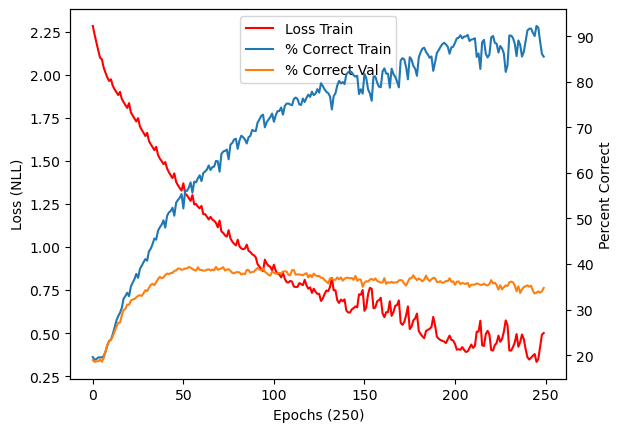

In [6]:
acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[10, 10],
    patch_size_per_conv_layer=[5, 5],
    stride_per_conv_layer=[1, 2],
    n_hiddens_per_fc_layer=[10],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=5,
    n_reps=50,
    device='cuda')   # or 'cpu'

The original model doesn't perform well. Training accuracy is high while validation and testing accuracy are low. This indicates that the model is overfitting to the training data.

<br>

5. Perform additional experiments with the CIFAR-10 data to investigate these questions:
    1. Do more or fewer layers of convolutional units work better?
    2. How well does a network without convolutional layers work on this data?
    3. Do more or fewer layers of fully-connected units work better?
    4. How well does a network without fully connected layers work on this data?
    3. For what cases do you see overfitting occurring?
6. Examine the weights in the first layer.  Draw the weights as images.  Do they make sense, given the kinds of images you are classifying? 

## Do more or fewer layers of convolutional units work better?

Accuracy Train 95.12 Val 33.12 Test 34.06
Training took 1.15 minutes.


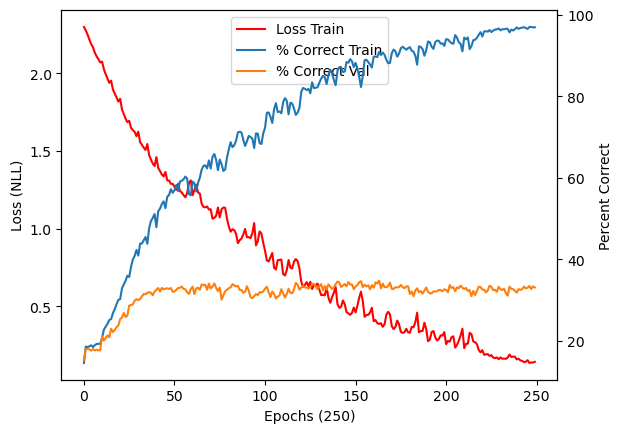

In [8]:
# Model with fewer convolutional layer
acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[10],
    patch_size_per_conv_layer=[5],
    stride_per_conv_layer=[1],
    n_hiddens_per_fc_layer=[10],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=5,
    n_reps=50,
    device='cuda')   # or 'cpu'

The overfitting issue remains with lesser convolutional layer (one layer with 10 units here). Training accuracy is very high while validation and testing accuracy are low.

<br>

Accuracy Train 73.04 Val 38.1 Test 38.16
Training took 1.96 minutes.


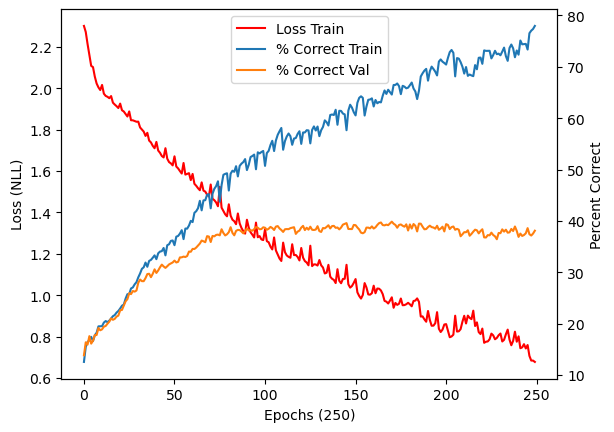

In [13]:
# Model with more convolutional layer
acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[20, 20, 10, 10, 10],
    patch_size_per_conv_layer=[5, 5, 5, 3, 3],
    stride_per_conv_layer=[1, 2, 1, 1, 1],
    n_hiddens_per_fc_layer=[10],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=5,
    n_reps=50,
    device='cuda')   # or 'cpu'

With more convolutional hidden units in the model ([20, 20, 10, 10, 10], added more units in first two convolutional layer), the overfitting issue starts to improve though not totally resolved. Comared to the previous models with lesser number of convolutional layers, the difference between training and validation accuracy decreases. In previous models, training vs validation accuracies were ~90% and ~33%, respectively. In the new model with more layers, training accuracy reduces to 73% and validation but the validation accuracy doesn't improve much. But the training pattern in the plot indicates that the model is learning better and performance will get better if we keep trying different model structures.

<br>

## How well does a network without convolutional layers work on this data?

Accuracy Train 10.38 Val 10.26 Test 10.22
Training took 0.92 minutes.


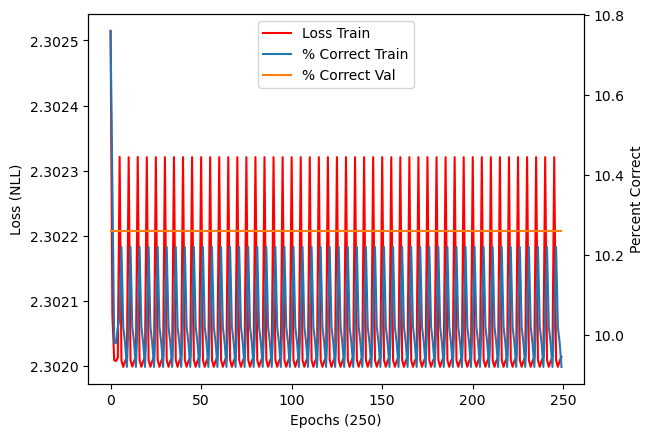

In [17]:
# Model with no convolutional layer
acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[],
    patch_size_per_conv_layer=[],
    stride_per_conv_layer=[],
    n_hiddens_per_fc_layer=[10],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=5,
    n_reps=50,
    device='cuda')   # or 'cpu'

A cnn model with no convolutional layer doesn't seem to work on the CIFAR-10 dataset. From the plot, it seems like the model tries to recognize some pattern initially but both training and validation accuracy remains low near ~10% finally.

<br>

## Do more or fewer layers of fully-connected units work better?

Accuracy Train 10.4 Val 10.26 Test 10.22
Training took 1.12 minutes.


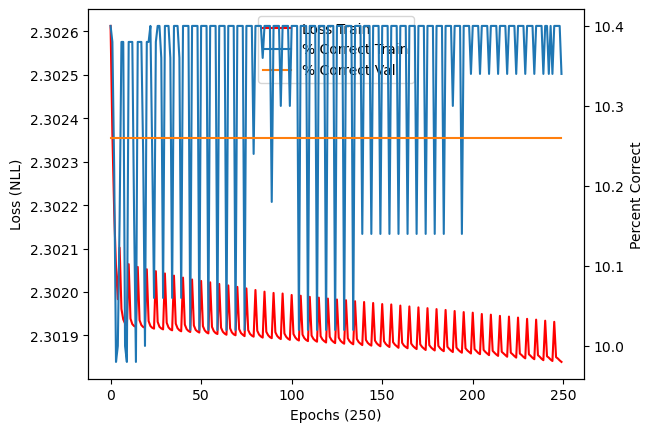

In [18]:
# Model with no convolutional layer, more fully connected layer
acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[],
    patch_size_per_conv_layer=[],
    stride_per_conv_layer=[],
    n_hiddens_per_fc_layer=[20, 10, 10],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=5,
    n_reps=50,
    device='cuda')   # or 'cpu

Accuracy Train 10.4 Val 10.26 Test 10.22
Training took 0.96 minutes.


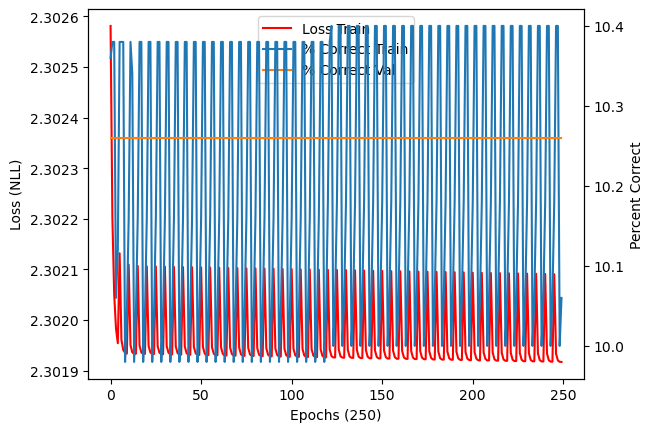

In [19]:
# Model with no convolutional layer, single fully connected layer with lesser unit
acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[],
    patch_size_per_conv_layer=[],
    stride_per_conv_layer=[],
    n_hiddens_per_fc_layer=[5],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=5,
    n_reps=50,
    device='cuda')   # or 'cpu

Cnn model with lesser and more fully connected layers but no convolutional layer doesn't seem to work either.Both the training and validation accuracy remains low near ~10%. It seems like convolutional layer is a must for such type (image) of dataset classification.

<br>

## How well does a network without fully connected layers work on this data?

Accuracy Train 75.76 Val 42.4 Test 41.78
Training took 1.92 minutes.


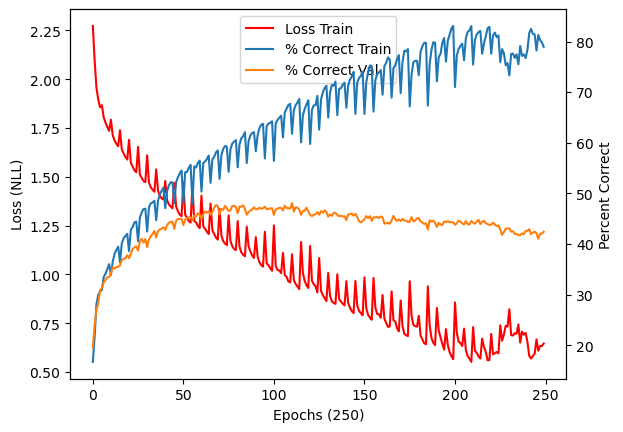

In [20]:
# Model with no fully connected layer
acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[20, 20, 10, 10, 10],
    patch_size_per_conv_layer=[5, 5, 5, 3, 3],
    stride_per_conv_layer=[1, 2, 1, 1, 1],
    n_hiddens_per_fc_layer=[],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=5,
    n_reps=50,
    device='cuda')   # or 'cpu'

Here, the Cnn model The cnn model has [20, 20, 10, 10, 10] convolution layers but no fully connected layer. It performs quite well on the CIFAR-10 data, as good as the model we developed before with the same number of convolution layer and one fully connected layer. The overfitting issue improves compared to the initial model (one convolution layer, one fully connected layer). Running experiments with different model structure might lead towards a model with better accuracy. 

<br>

# For what cases do you see overfitting occurring?

2


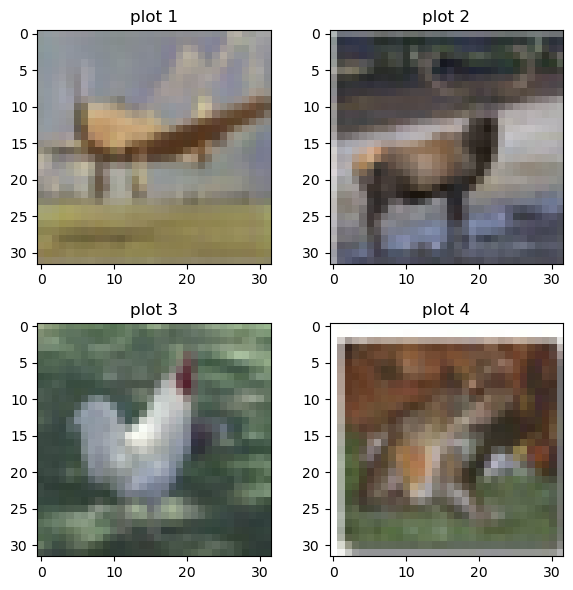

In [41]:
# Visualizing the data

x1 = Xtest[20:21].squeeze()
x1 = np.moveaxis(x1, 0, -1)

x2 = Xtest[500:501].squeeze()
x2 = np.moveaxis(x2, 0, -1)

x3 = Xtest[1500:1501].squeeze()
x3 = np.moveaxis(x3, 0, -1)

x4 = Xtest[4003:4004].squeeze()
x4 = np.moveaxis(x4, 0, -1)

imgs = [x1, x2, x3, x4]
nrow, ncol = int(len(imgs)/2), int(len(imgs)/2)
print(nrow)

plt.subplots(figsize=(6, 6))
for i in range(1, 5):
    plt.subplot(nrow, ncol, i)
    plt.imshow(imgs[i-1])
    plt.title(f'plot {i}')
plt.tight_layout()

Plot 1 is a plane, plot 2 a deer (maybe!), and plot 3 is a chicken. Plot 4 is totally unrecognizable. 

#### Reasons behind overfitting

The images are of coarse resolution and sometimes even difficlut for human eyes to tetect clearly (i. e., plot 2 and 4). There are a lot of background noises (different backgrounds) in the images. If the object and background has similar color combination (being RGB images) it becomes more difficult for the model. Therefore, it is difficult for the model to detect a object if it has not experienced something similar in the training data. Moreover, number of samples in training data in relatively low for the model. Model performance on the training data is relatively high, meaning the model is able to recognize the object it is trained on. But for anything new, the performance is not good. 

Another hypothesis is - in general it is difficult to train a model to recognize natural objects. Natural objects come at different shapes, sizes, orientations, and looks. A very large and robust dataset is required in such cases.  

Overall, I think these are the reasons that caused model overfitting.

Accuracy Train 90.16999999999999 Val 37.28 Test 38.0
Training took 13.90 minutes.


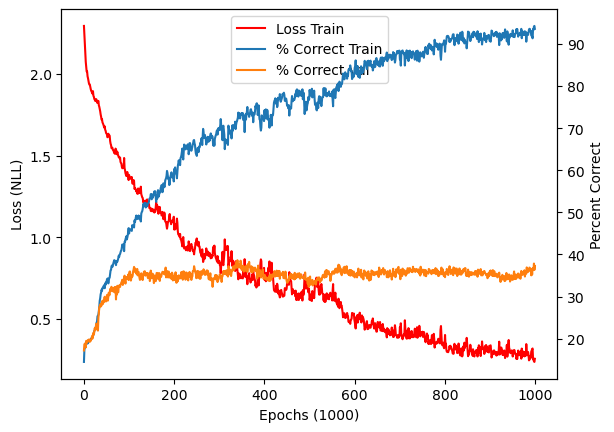

In [42]:
# Model with deep convolution structure, more fully connected layer, more epochs. More samples in the training dataset

n_train = 10000
n_val = 2500
n_test = 2500

first = 0
last = n_train + first
Xtrain = X[first:last, ...]
Ttrain = T[first:last]

first = last
last = last + n_val
Xval = X[first:last, ...]
Tval = T[first:last, ...]

first = last
last = last + n_test
Xtest = X[first:last, ...]
Ttest = T[first:last]


acc_train, acc_val, acc_test, nnet = run_experiment(
    n_hiddens_per_conv_layer=[20, 20, 10, 10, 10],
    patch_size_per_conv_layer=[5, 5, 5, 3, 3],
    stride_per_conv_layer=[1, 2, 1, 1, 1],
    n_hiddens_per_fc_layer=[20, 10, 5],
    batch_size=200,
    learning_rate=0.0005,
    method='adam',
    n_epochs=20,
    n_reps=50,
    device='cuda')   # or 'cpu'

To observe, if more training data, better model structure, and more epochs improve model performance, I ran a new model. Unfortunately, the model overfitting issue remains. May be my hypothesis about difficulty in training a model for natural objects is true.

<br>

# Examine the weights in the first layer. Draw the weights as images. Do they make sense, given the kinds of images you are classifying?

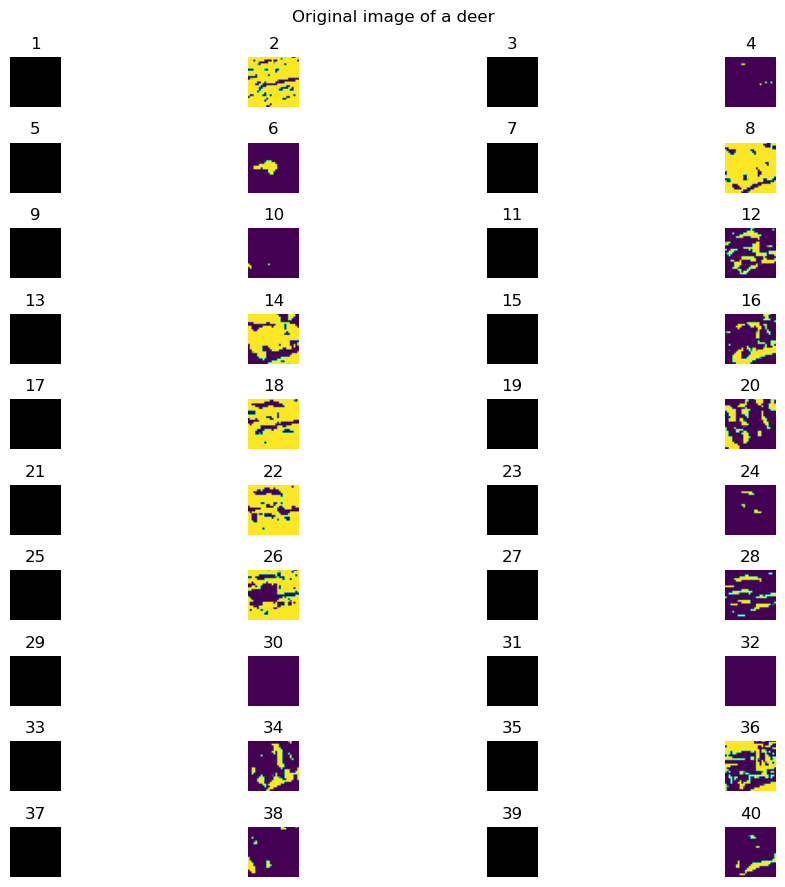

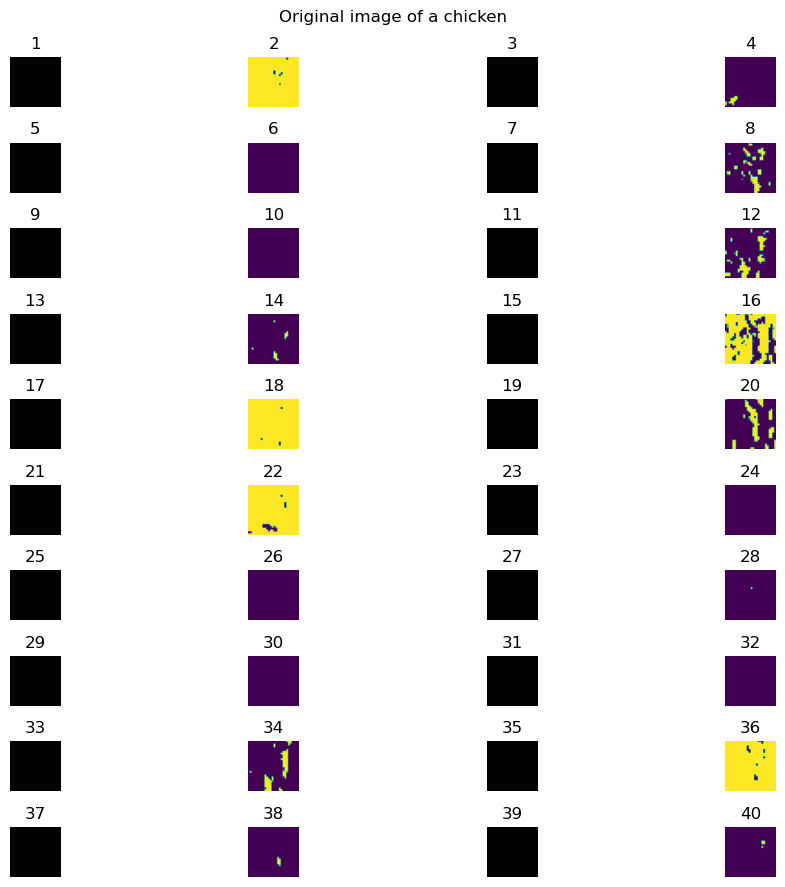

In [61]:
layerweights = list(nnet.children())[0][0].weight.data  # layerweights is 1st weight of cnn model nnet
# layerweights = np.moveaxis(layerweights, 0, -1)

# Using the x2, and x3 test images that I plotted earlier (deer, chichekn)
x2 = Xtest[500:501]
x3 = Xtest[1500:1501]

x2 = torch.from_numpy(x2).float().to('cuda')
Ys_2 = nnet._forward_all_outputs(x2)

x3 = torch.from_numpy(x3).float().to('cuda')
Ys_3 = nnet._forward_all_outputs(x3)


max_plot = layerweights.shape[0] * 2

ploti = 0
plt.subplots(figsize=(12, 9))
for i in range(20):
    if ploti < max_plot:
        ploti+=1
        plt.subplot(10, 4, ploti)
        weight_to_plot = layerweights[i].squeeze().cpu().numpy()
        weight_to_plot = np.moveaxis(weight_to_plot, 0, -1)
        plt.imshow(weight_to_plot.astype(np.uint8))
        plt.title(ploti)
        plt.axis('off')
        ploti+=1
        plt.subplot(10, 4, ploti)
        plt.imshow(Ys_2[1][0, i, :, :].detach().squeeze().cpu())
        plt.title(ploti)
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Original image of a deer')
    
ploti = 0
plt.subplots(figsize=(12, 9))
for i in range(20):
    if ploti < max_plot:
        ploti+=1
        plt.subplot(10, 4, ploti)
        weight_to_plot = layerweights[i].squeeze().cpu().numpy()
        weight_to_plot = np.moveaxis(weight_to_plot, 0, -1)
        plt.imshow(weight_to_plot.astype(np.uint8))
        plt.title(ploti)
        plt.axis('off')
        ploti+=1
        plt.subplot(10, 4, ploti)
        plt.imshow(Ys_3[1][0, i, :, :].detach().squeeze().cpu())
        plt.title(ploti)
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Original image of a chicken')

Column 1 and 3 are `weights` before first convolution hidden layer. Column 2 and 4 are `convolved weights` after activation function. The original images were of a deer and chicken, respectively. But the weights is not recognizable to me and I couldn't relate them to the original images.

# Extra Credit

Try using all of the CIFAR-10 data, meaning all six batches of data. Train and test your network on a GPU.  Report results, including training time.